In [6]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, max_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Load dataset
DATA_FILE = '../../data/crypto-markets.csv'
df = pd.read_csv(DATA_FILE)


Processing slug: bitcoin
Best k: 1
Performance Metrics for bitcoin:
               Metric        Value
0  Explained Variance     0.575317
1           Max Error  9679.050000
2                RMSE  2199.725297
3                 MAE  1285.785138
4           R-Squared     0.465979


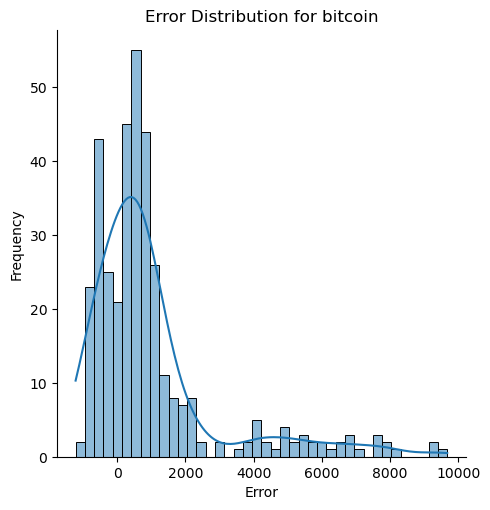

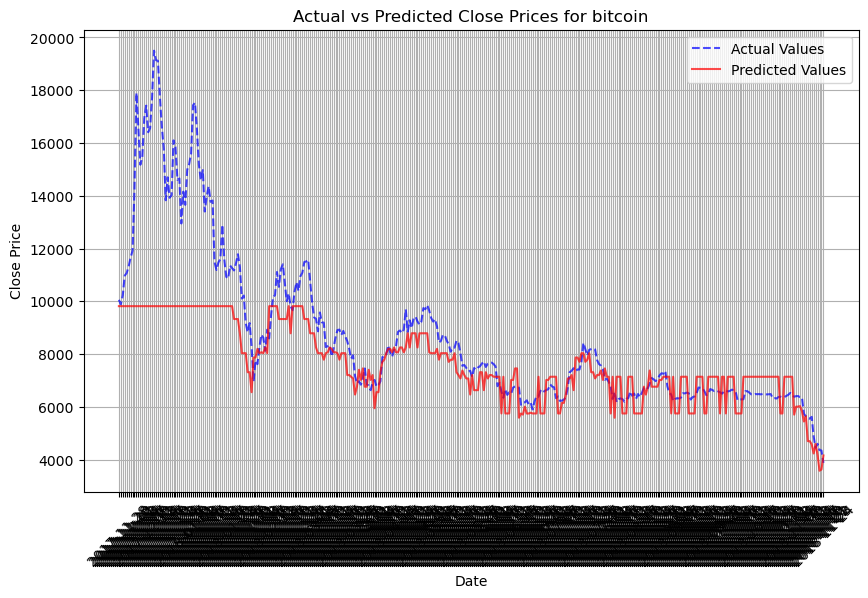


Processing slug: ripple
Best k: 6
Performance Metrics for ripple:
               Metric     Value
0  Explained Variance  0.011824
1           Max Error  3.058732
2                RMSE  0.625896
3                 MAE  0.395036
4           R-Squared -0.632621


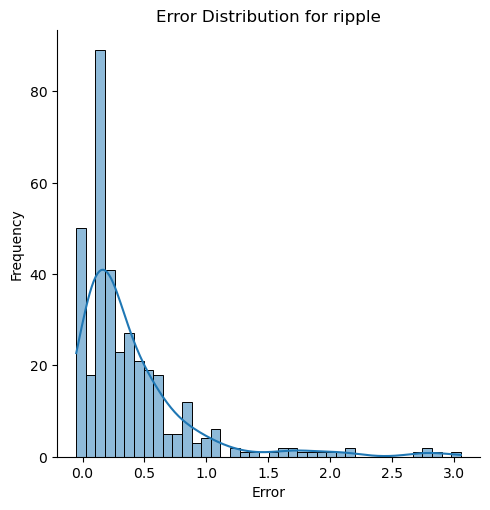

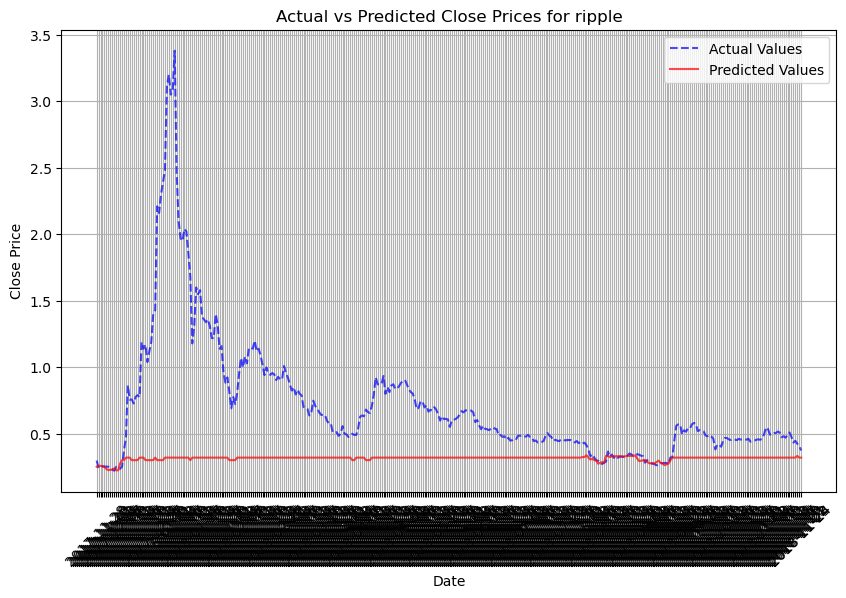


Processing slug: ethereum
Best k: 2
Performance Metrics for ethereum:
               Metric       Value
0  Explained Variance    0.407940
1           Max Error  953.880000
2                RMSE  270.888603
3                 MAE  172.025249
4           R-Squared    0.050492


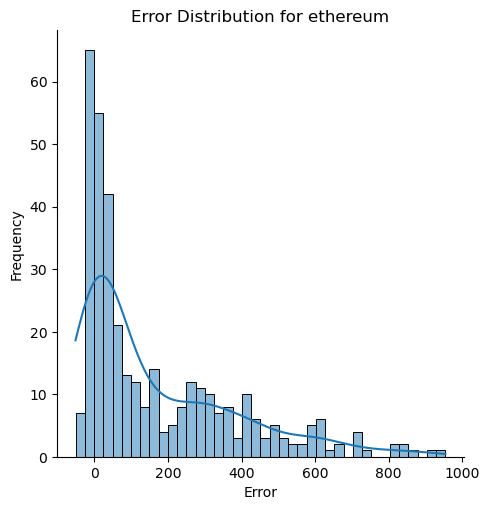

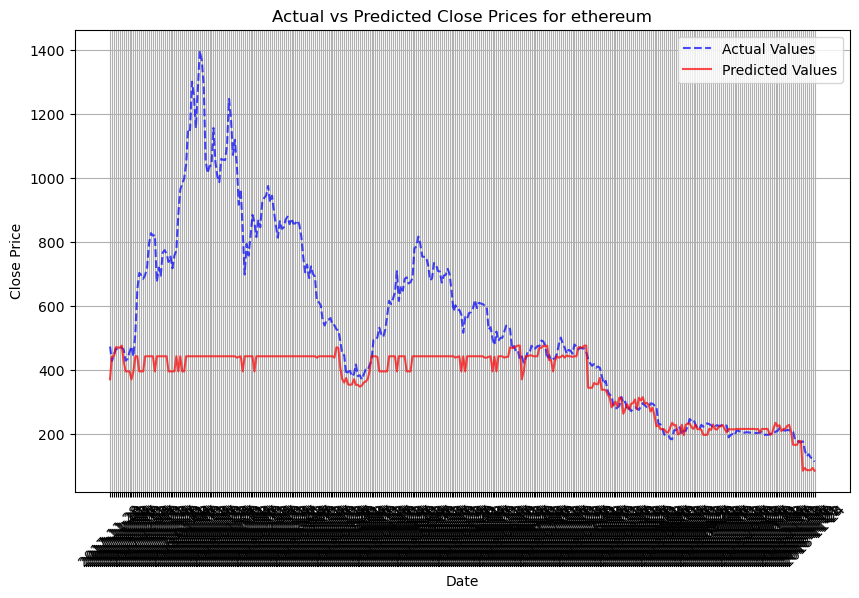


Processing slug: stellar
Best k: 12
Performance Metrics for stellar:
               Metric     Value
0  Explained Variance  0.001388
1           Max Error  0.847463
2                RMSE  0.270092
3                 MAE  0.242100
4           R-Squared -4.081030


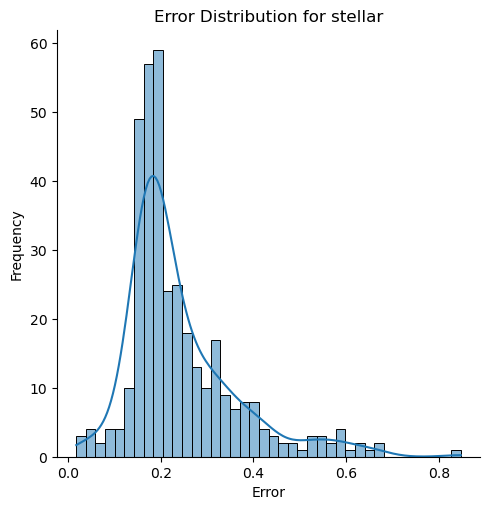

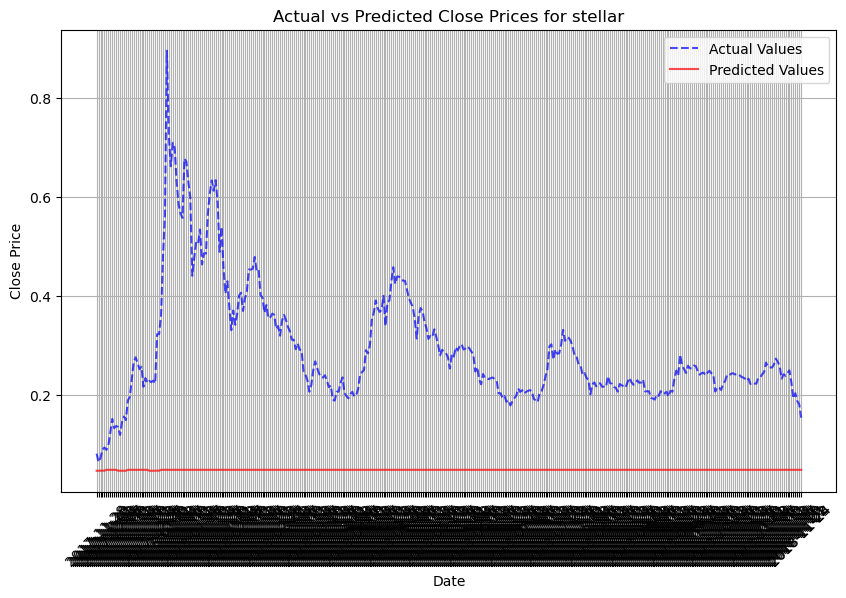


Processing slug: bitcoin-cash
Best k: 6
Performance Metrics for bitcoin-cash:
               Metric        Value
0  Explained Variance     0.685312
1           Max Error  2403.148333
2                RMSE   383.744993
3                 MAE   196.617468
4           R-Squared     0.637770


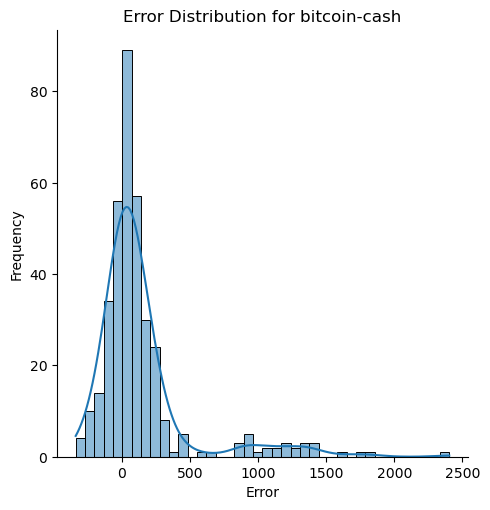

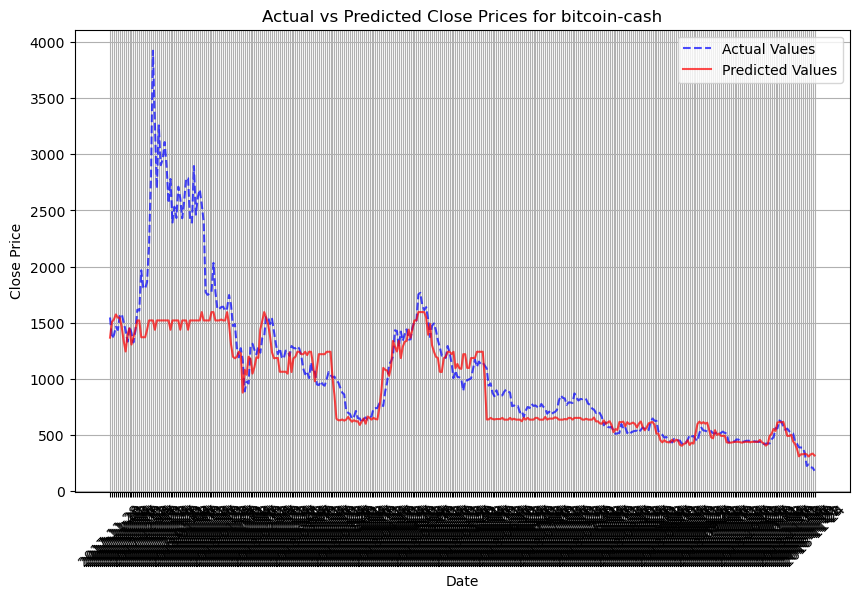


Processing slug: eos
Best k: 3
Performance Metrics for eos:
               Metric      Value
0  Explained Variance  -0.016128
1           Max Error  19.346667
2                RMSE   7.059633
3                 MAE   6.065028
4           R-Squared  -2.878553


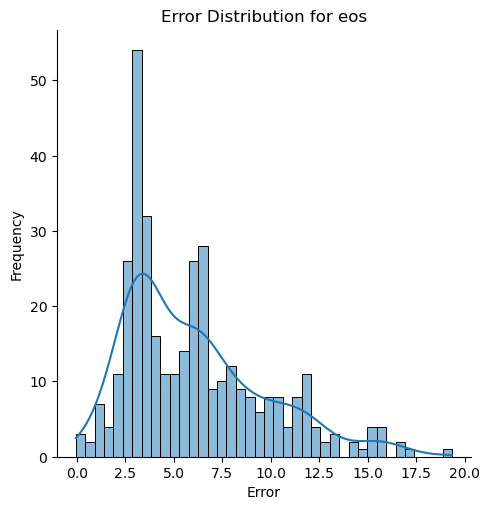

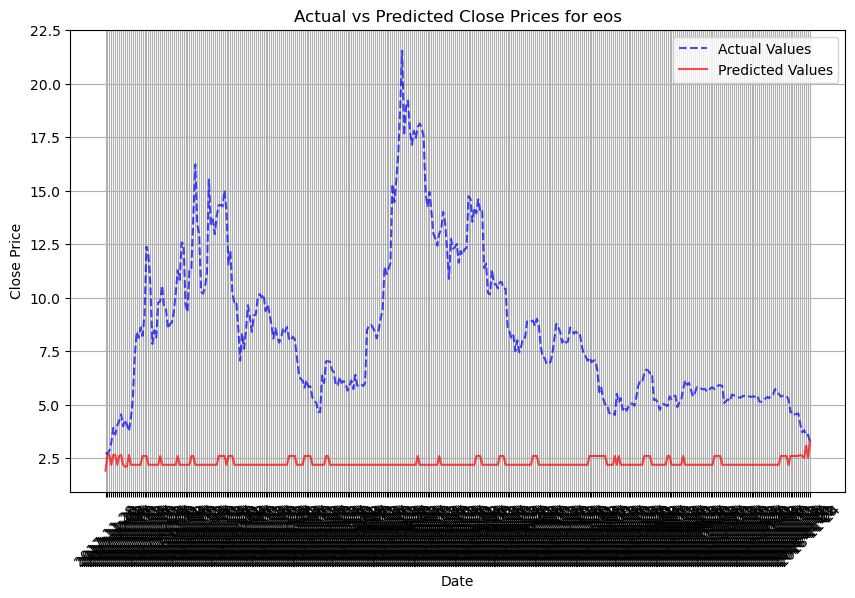


Processing slug: litecoin
Best k: 5
Performance Metrics for litecoin:
               Metric       Value
0  Explained Variance    0.243892
1           Max Error  274.832000
2                RMSE   79.163041
3                 MAE   51.205829
4           R-Squared   -0.282478


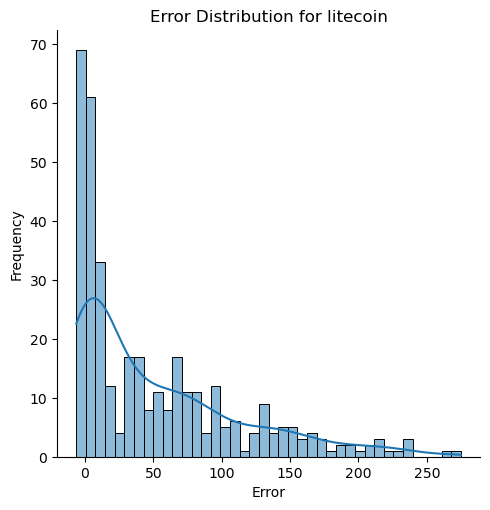

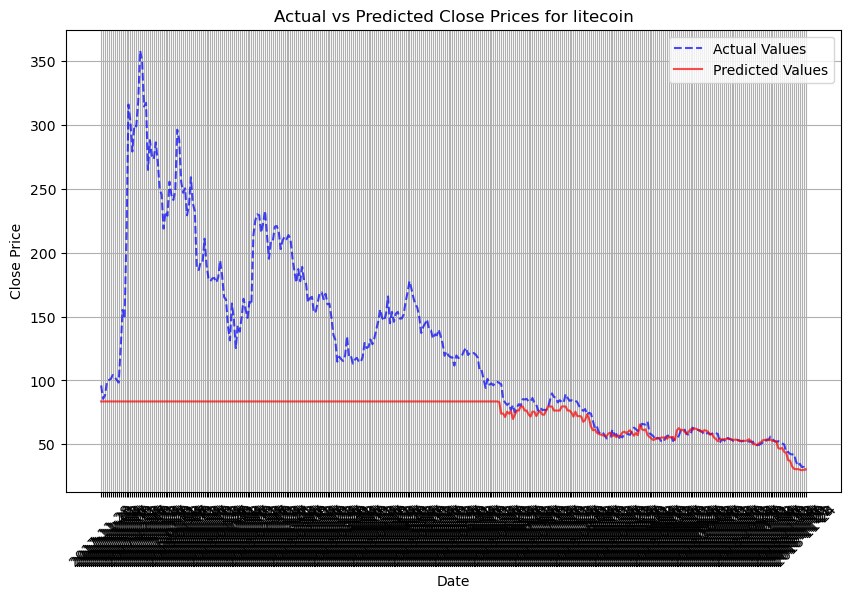


Processing slug: tether
Best k: 2
Performance Metrics for tether:
               Metric     Value
0  Explained Variance  0.122410
1           Max Error  0.070000
2                RMSE  0.008668
3                 MAE  0.004675
4           R-Squared  0.118063


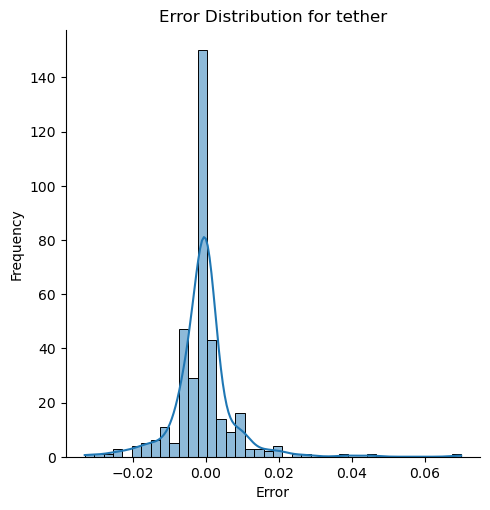

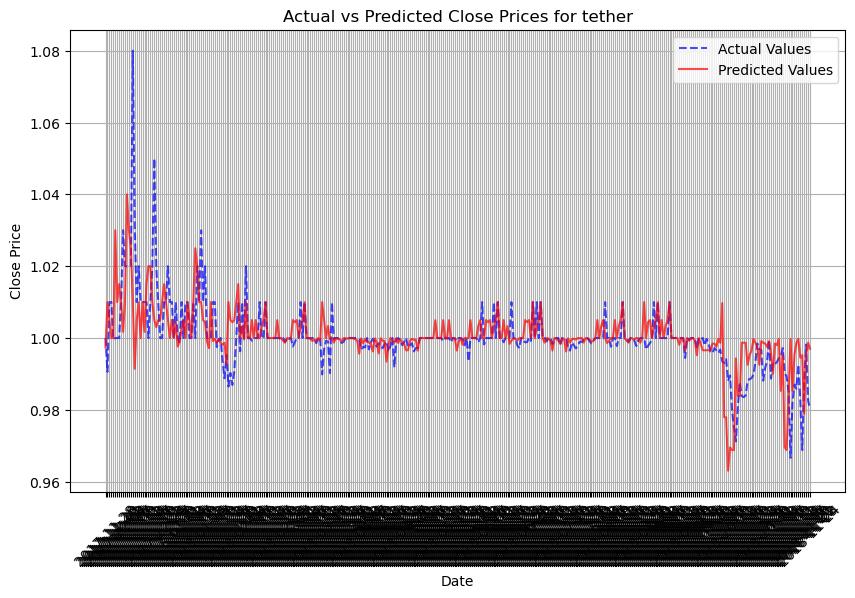


Processing slug: bitcoin-sv
Skipping bitcoin-sv due to empty train/test datasets.

Processing slug: cardano
Best k: 10
Performance Metrics for cardano:
               Metric     Value
0  Explained Variance  0.003154
1           Max Error  1.078751
2                RMSE  0.285016
3                 MAE  0.204704
4           R-Squared -1.058915


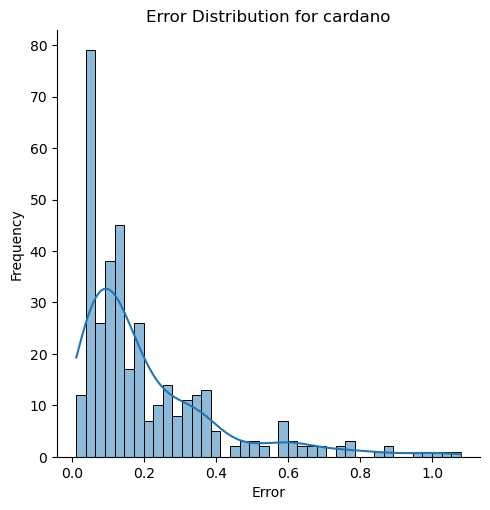

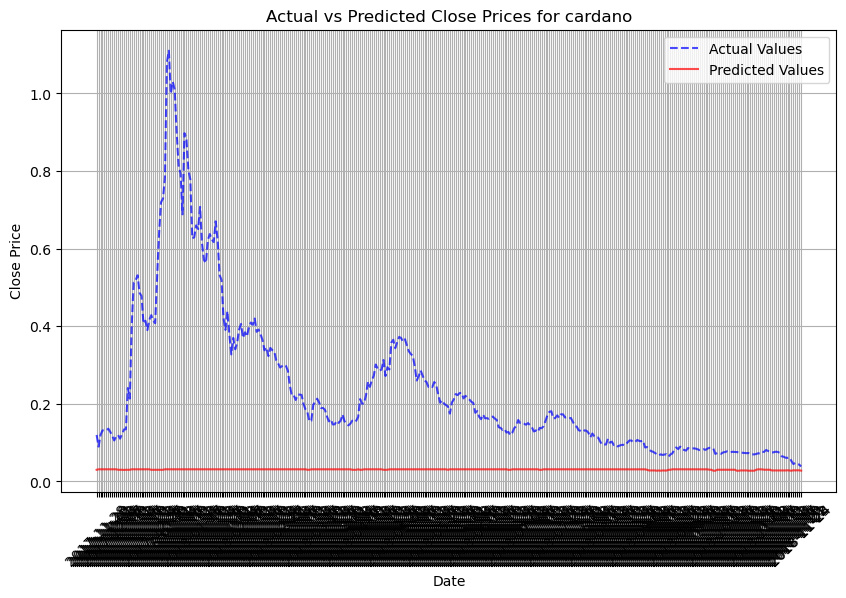


Processing slug: monero
Best k: 1
Performance Metrics for monero:
               Metric       Value
0  Explained Variance    0.449015
1           Max Error  295.810000
2                RMSE   87.747841
3                 MAE   55.704503
4           R-Squared    0.141209


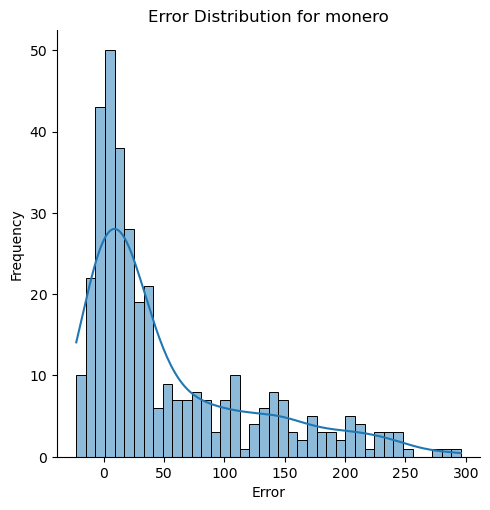

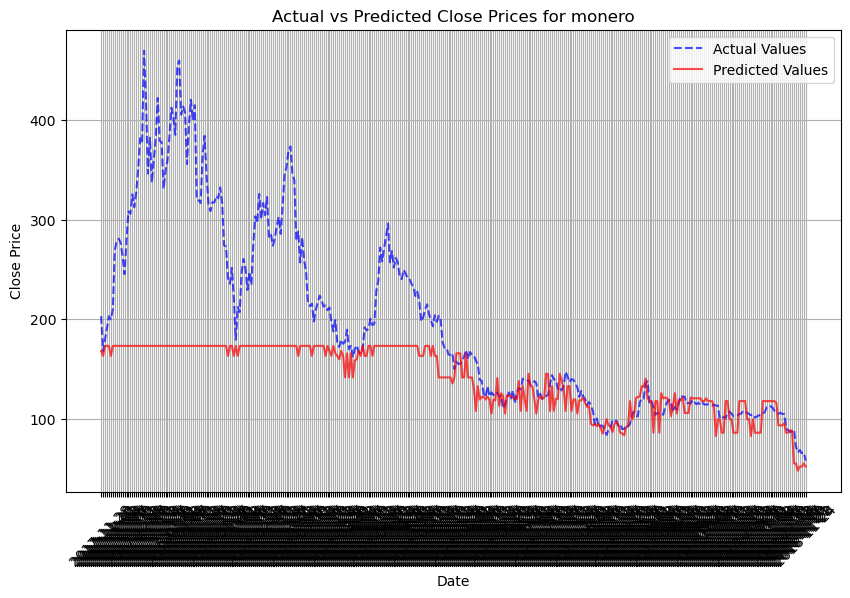


Processing slug: tron
Best k: 6
Performance Metrics for tron:
               Metric     Value
0  Explained Variance  0.001155
1           Max Error  0.217858
2                RMSE  0.048482
3                 MAE  0.039529
4           R-Squared -1.977399


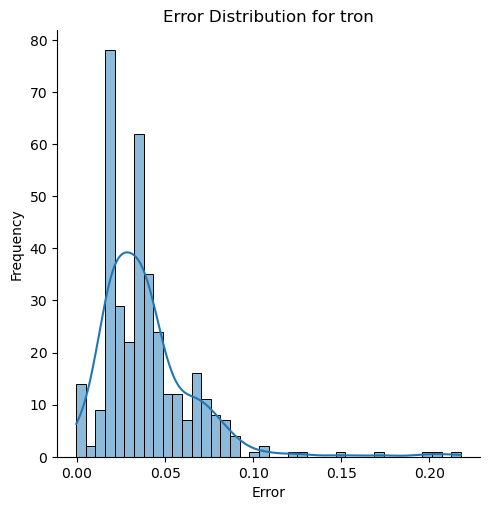

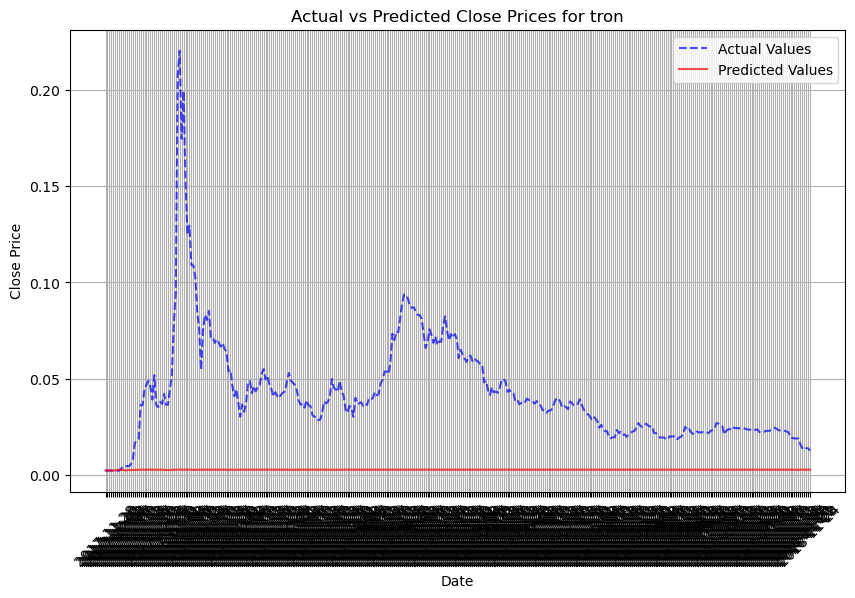


Processing slug: iota
Best k: 7
Performance Metrics for iota:
               Metric     Value
0  Explained Variance  0.159668
1           Max Error  4.487567
2                RMSE  1.251996
3                 MAE  0.764887
4           R-Squared -0.326486


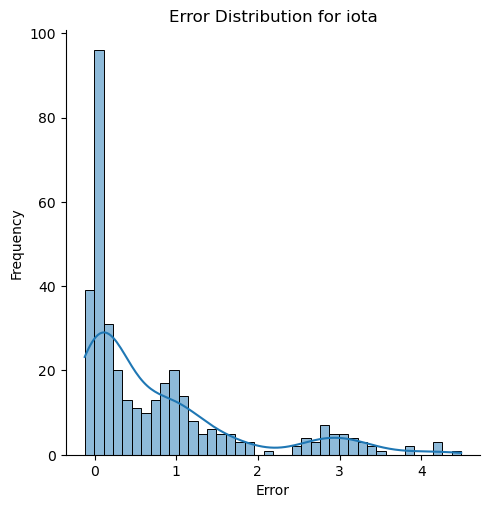

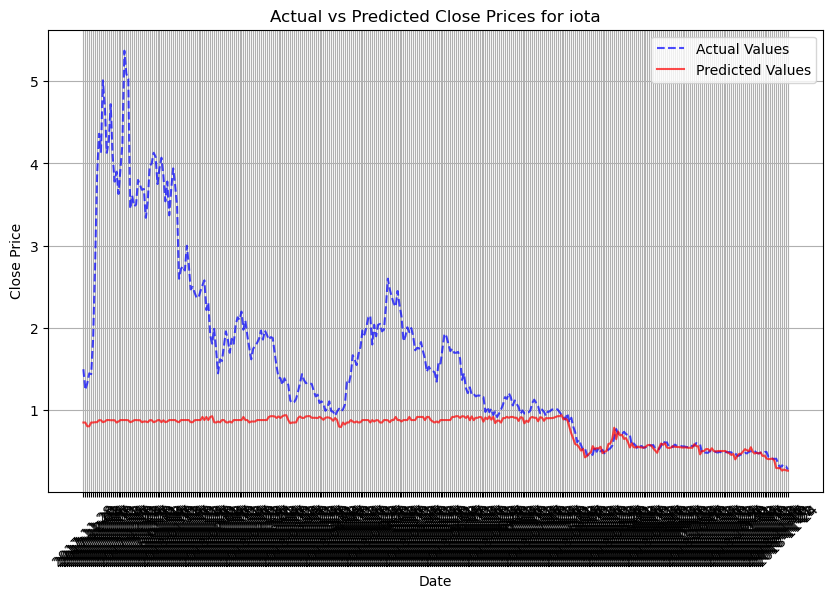


Processing slug: dash
Best k: 1
Performance Metrics for dash:
               Metric       Value
0  Explained Variance    0.721421
1           Max Error  918.550000
2                RMSE  174.274533
3                 MAE   91.837597
4           R-Squared    0.665505


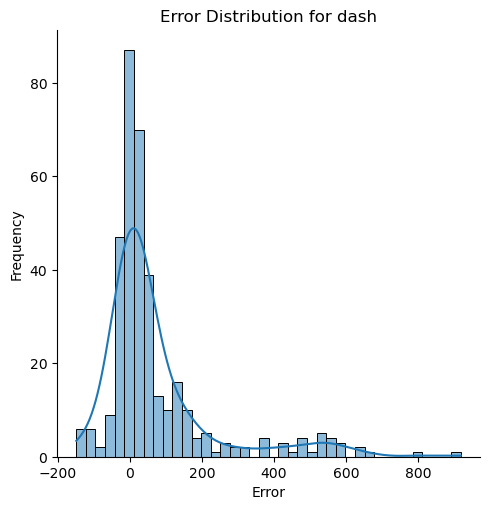

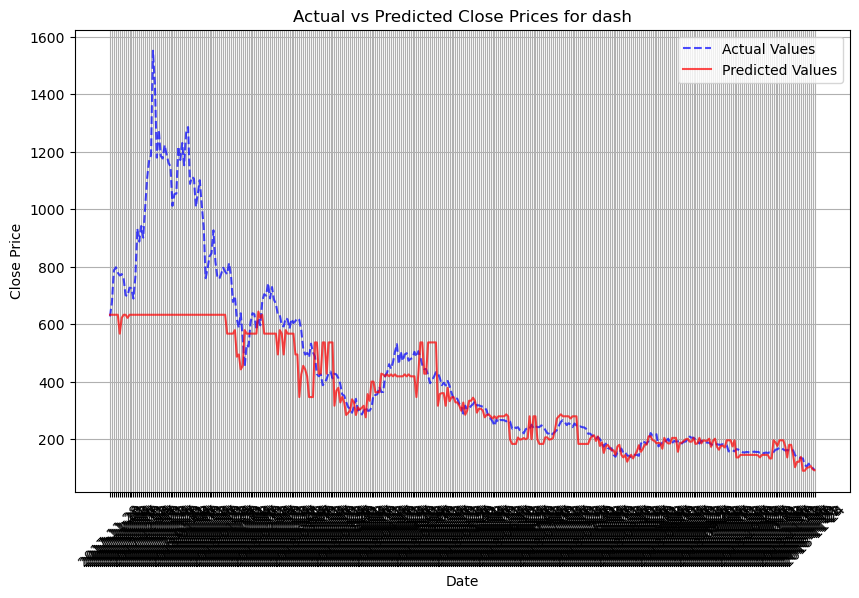


Processing slug: nem
Best k: 2
Performance Metrics for nem:
               Metric     Value
0  Explained Variance  0.253346
1           Max Error  1.550233
2                RMSE  0.331918
3                 MAE  0.152527
4           R-Squared  0.071683


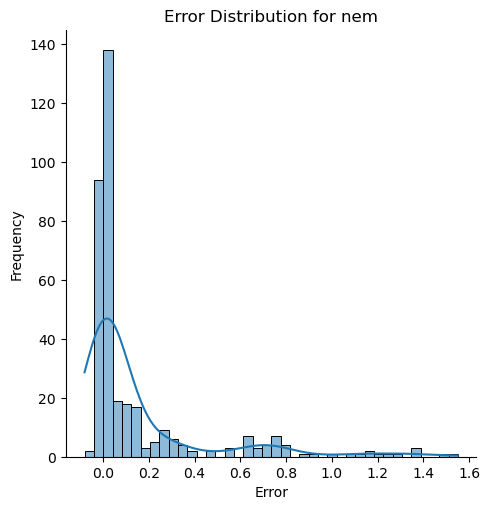

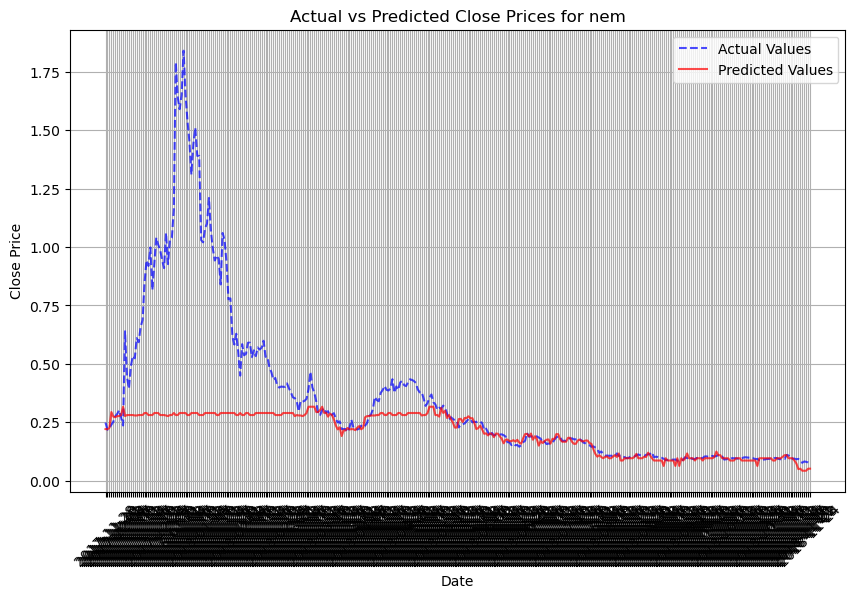


Processing slug: binance-coin
Best k: 4
Performance Metrics for binance-coin:
               Metric      Value
0  Explained Variance   0.010189
1           Max Error  20.525000
2                RMSE   9.504460
3                 MAE   8.858529
4           R-Squared  -6.518827


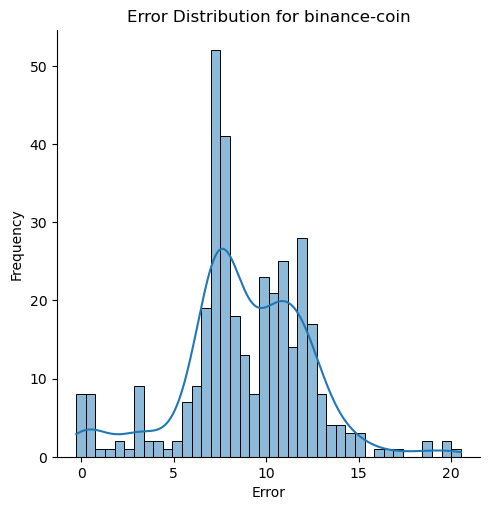

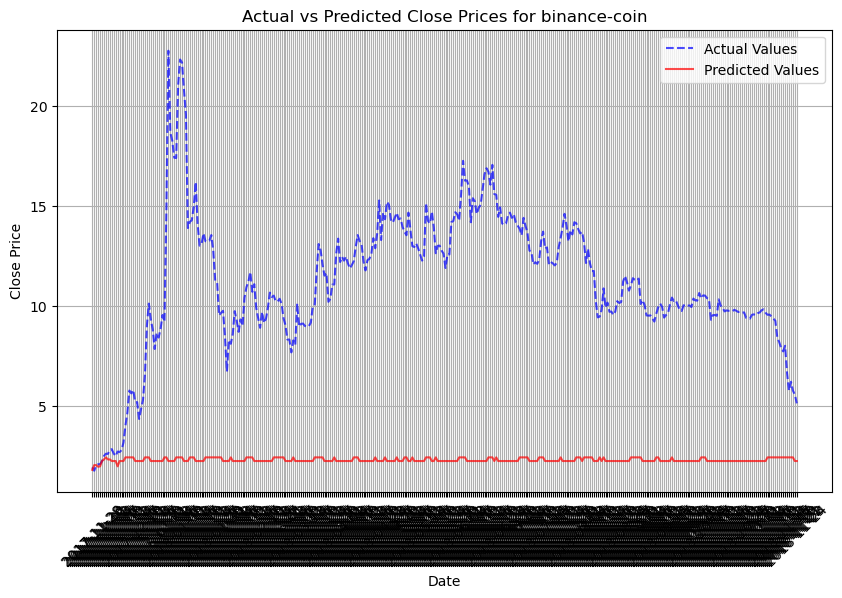


Processing slug: neo
Best k: 9
Performance Metrics for neo:
               Metric       Value
0  Explained Variance    0.273862
1           Max Error  149.015556
2                RMSE   40.775923
3                 MAE   24.819297
4           R-Squared   -0.082717


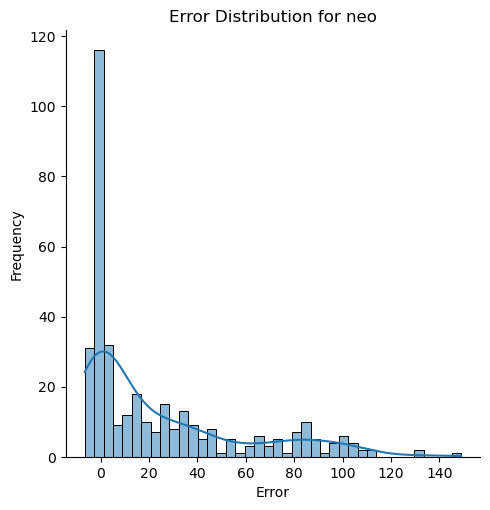

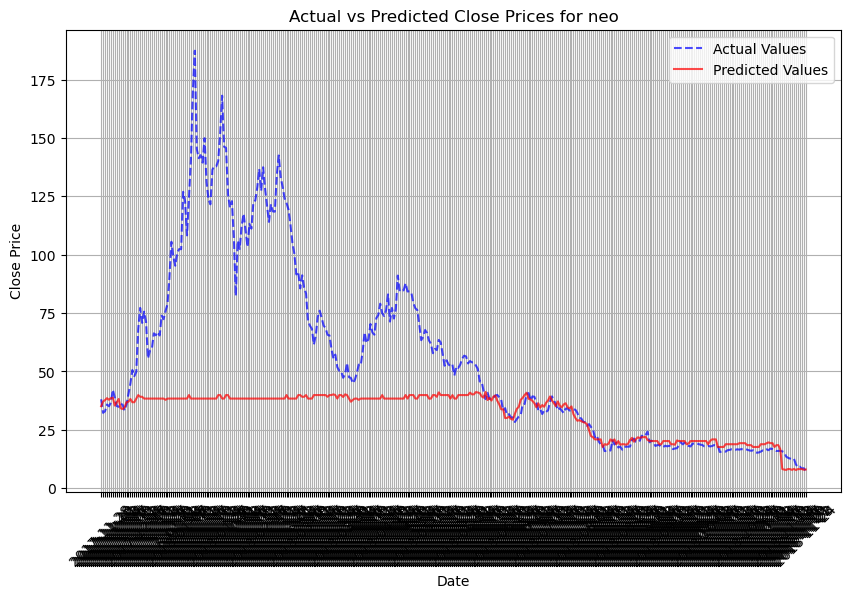


Processing slug: ethereum-classic
Best k: 5
Performance Metrics for ethereum-classic:
               Metric      Value
0  Explained Variance   0.646493
1           Max Error  22.178000
2                RMSE   5.960195
3                 MAE   3.460862
4           R-Squared   0.546701


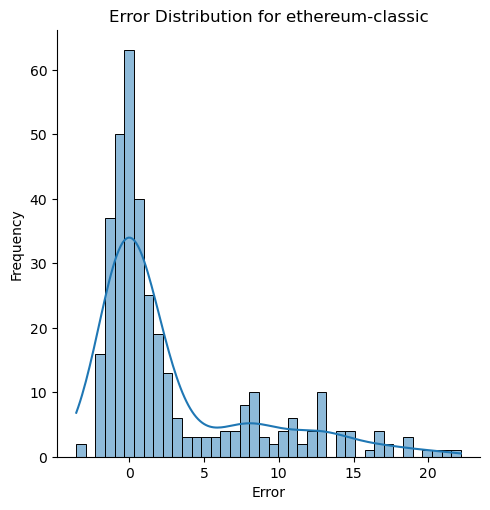

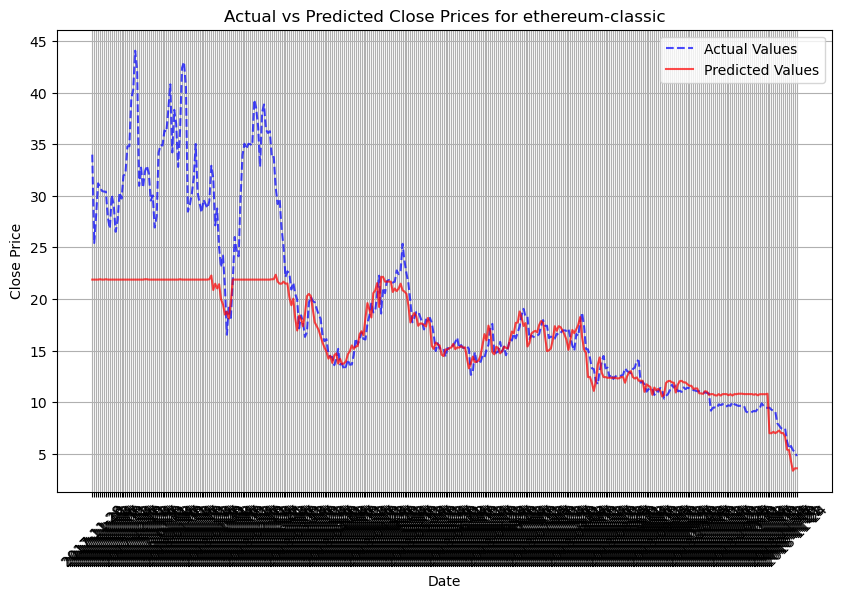


Processing slug: zcash
Best k: 4
Performance Metrics for zcash:
               Metric       Value
0  Explained Variance    0.787296
1           Max Error  351.382500
2                RMSE   71.990608
3                 MAE   42.425152
4           R-Squared    0.776868


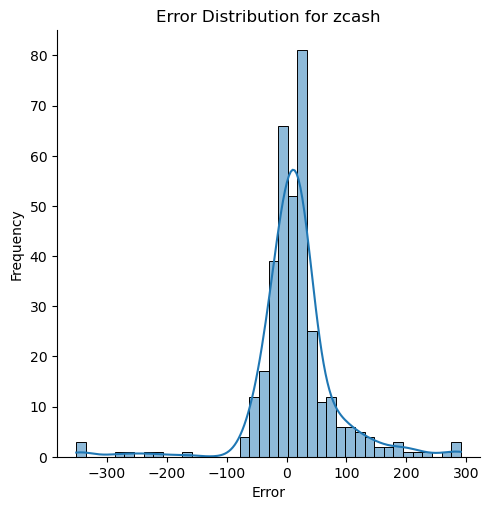

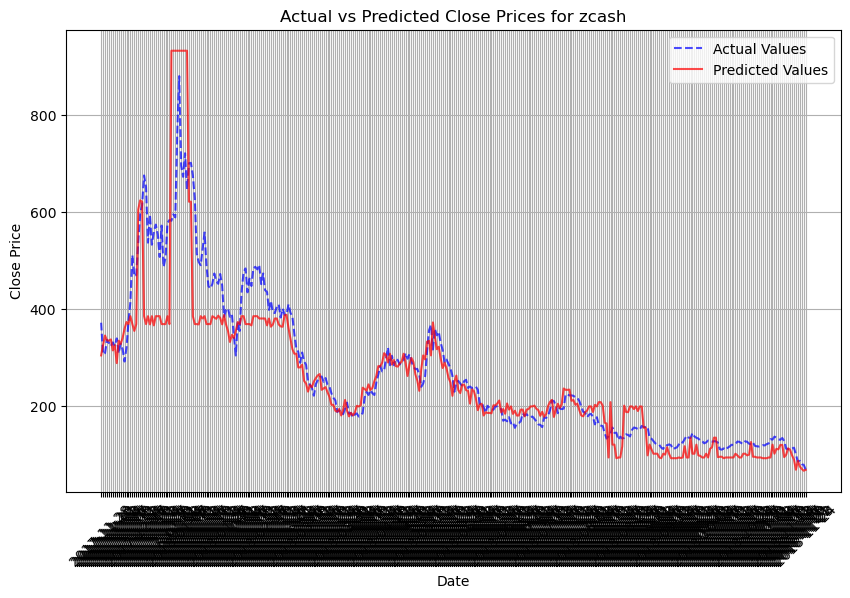


Processing slug: bitcoin-gold
Best k: 19
Performance Metrics for bitcoin-gold:
               Metric       Value
0  Explained Variance    0.353542
1           Max Error  209.610526
2                RMSE  120.912092
3                 MAE  112.503879
4           R-Squared   -0.717000


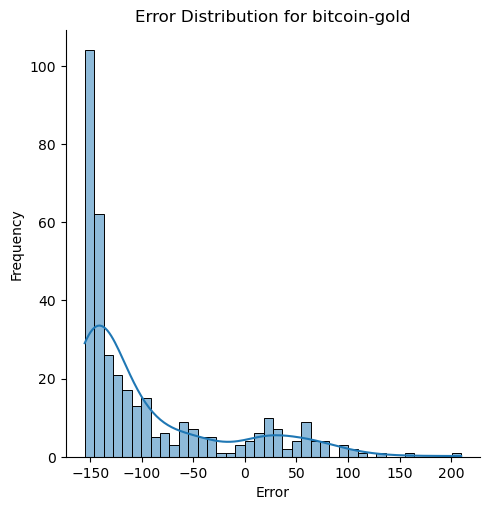

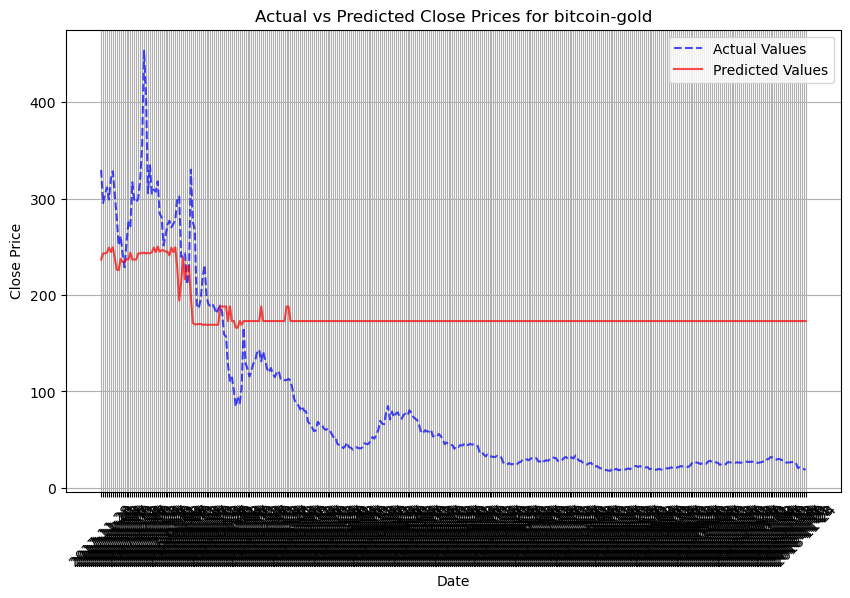


Processing slug: tezos
Best k: 6
Performance Metrics for tezos:
               Metric     Value
0  Explained Variance  0.335164
1           Max Error  8.125000
2                RMSE  1.466663
3                 MAE  1.032651
4           R-Squared  0.006188


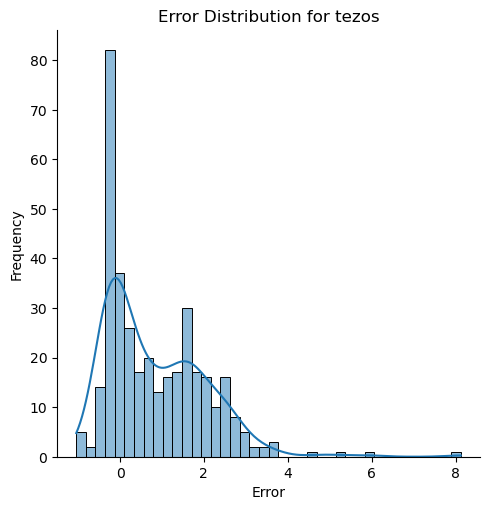

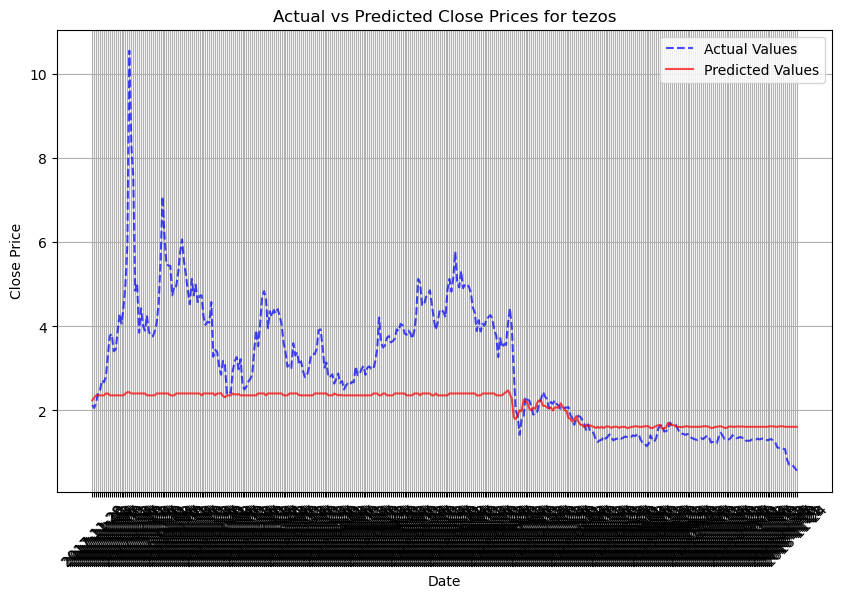


Processing slug: maker
Best k: 12
Performance Metrics for maker:
               Metric        Value
0  Explained Variance     0.000931
1           Max Error  1385.249167
2                RMSE   520.136746
3                 MAE   434.763773
4           R-Squared    -2.315524


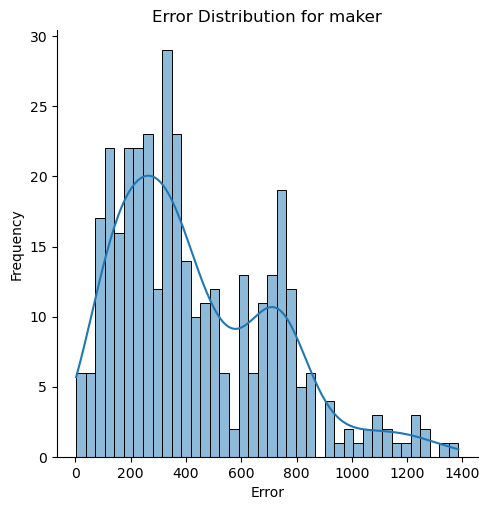

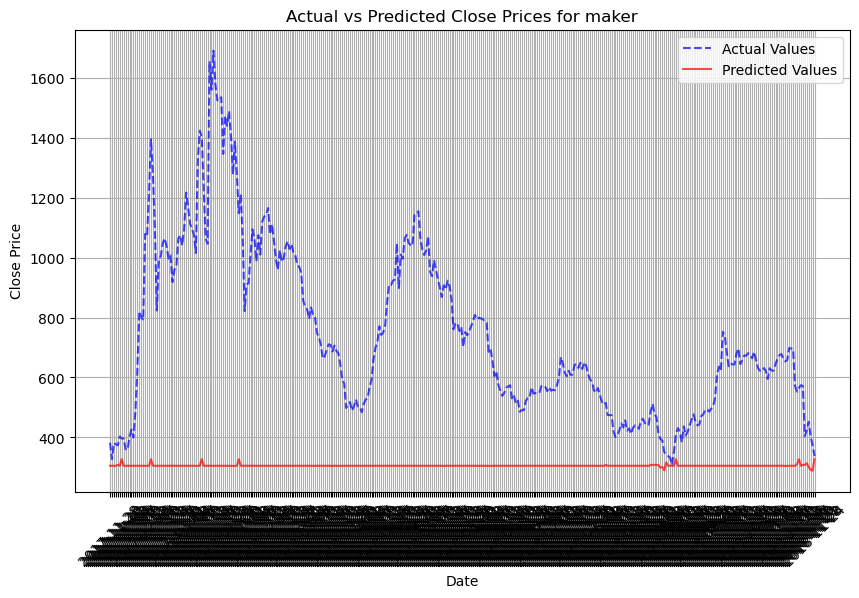


Processing slug: vechain
Skipping vechain due to empty train/test datasets.

Processing slug: dogecoin
Best k: 18
Performance Metrics for dogecoin:
               Metric     Value
0  Explained Variance  0.094981
1           Max Error  0.013902
2                RMSE  0.002679
3                 MAE  0.001656
4           R-Squared -0.372847


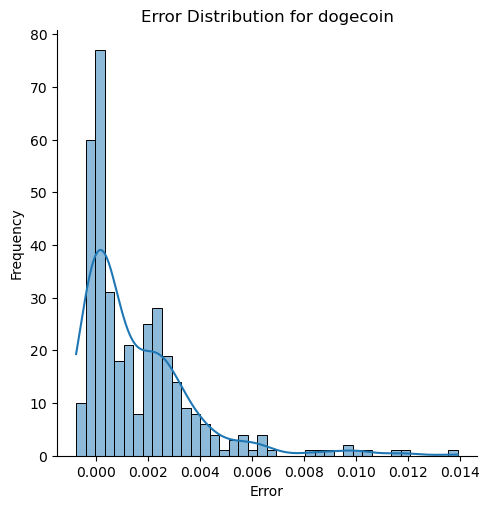

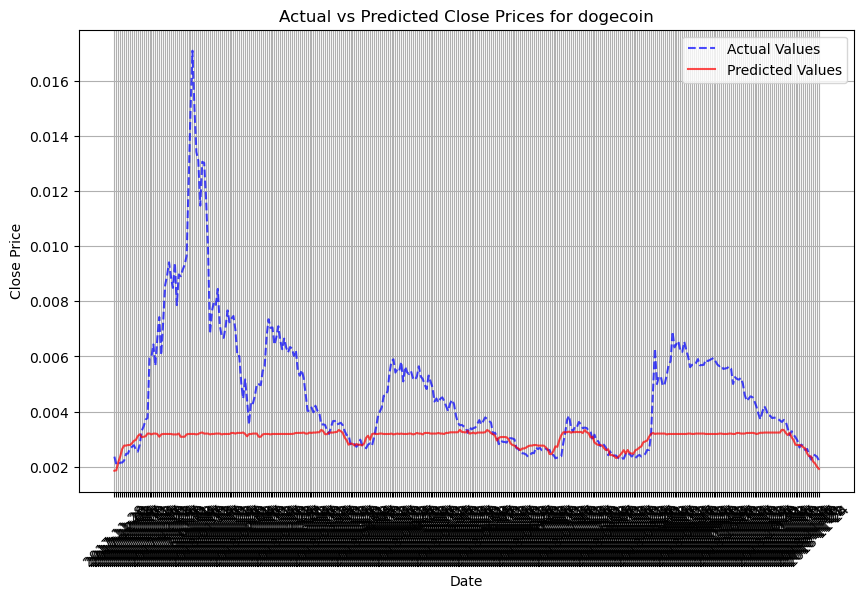


Processing slug: ontology
Skipping ontology due to empty train/test datasets.

Processing slug: 0x
Best k: 3
Performance Metrics for 0x:
               Metric     Value
0  Explained Variance -0.043803
1           Max Error  2.043703
2                RMSE  0.706320
3                 MAE  0.577250
4           R-Squared -2.029689


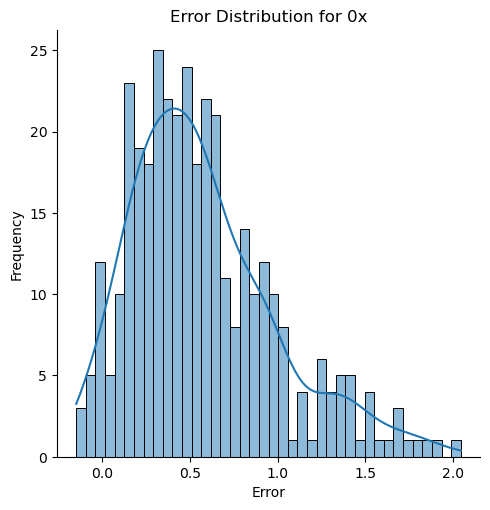

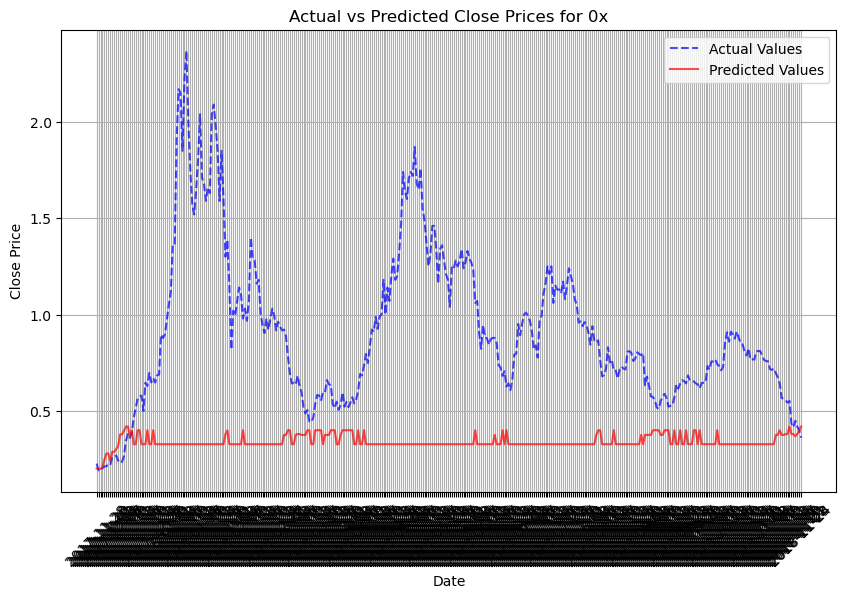


Processing slug: omisego
Best k: 6
Performance Metrics for omisego:
               Metric      Value
0  Explained Variance   0.713863
1           Max Error  14.856667
2                RMSE   3.860934
3                 MAE   2.573827
4           R-Squared   0.539747


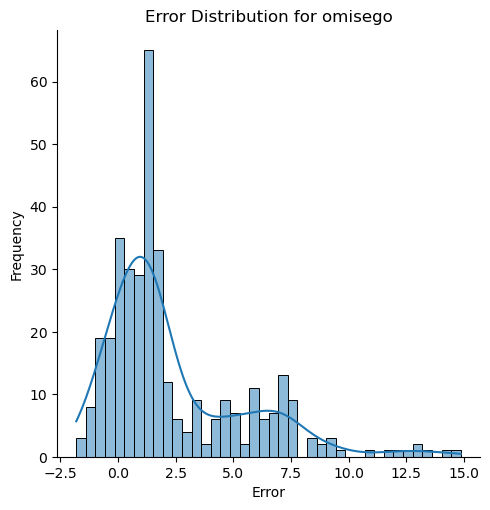

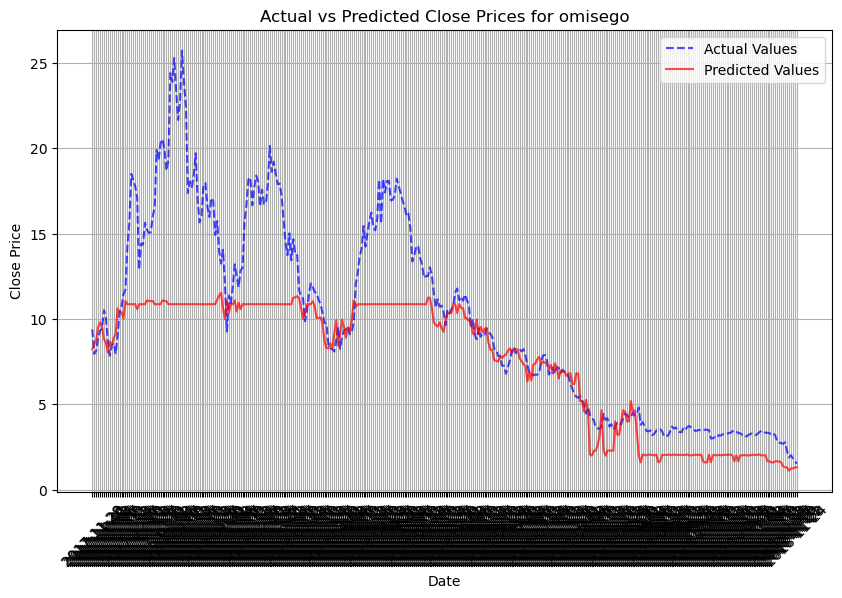


Processing slug: basic-attention-token
Best k: 4
Performance Metrics for basic-attention-token:
               Metric     Value
0  Explained Variance  0.089116
1           Max Error  0.672583
2                RMSE  0.153180
3                 MAE  0.092023
4           R-Squared -0.334099


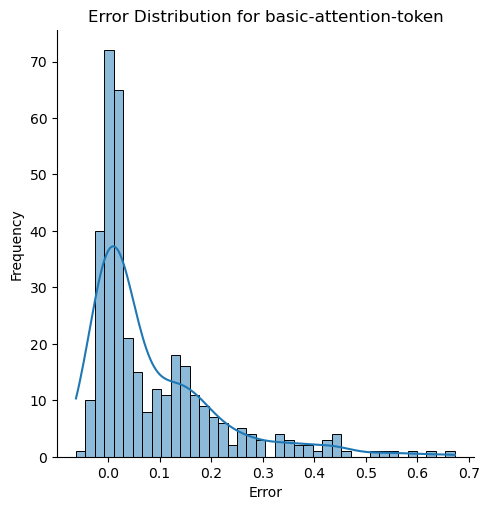

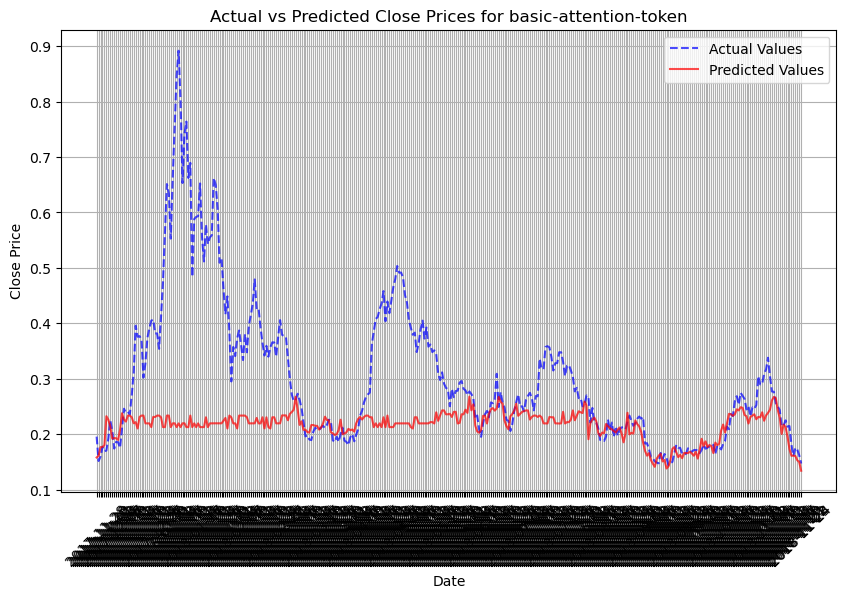


Processing slug: trueusd
Skipping trueusd due to empty train/test datasets.

Processing slug: qtum
Best k: 7
Performance Metrics for qtum:
               Metric      Value
0  Explained Variance   0.333924
1           Max Error  79.132857
2                RMSE  14.433019
3                 MAE   7.096957
4           R-Squared   0.187543


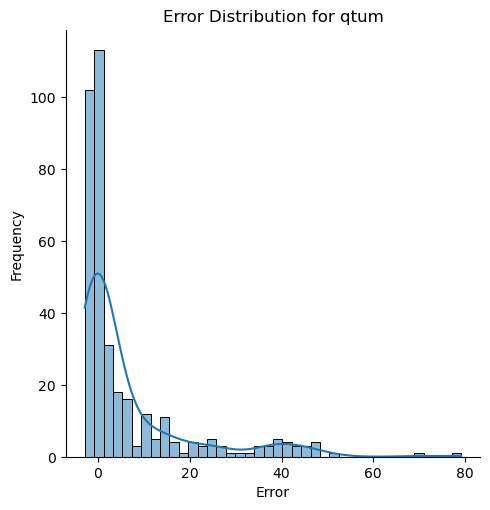

KeyboardInterrupt: 

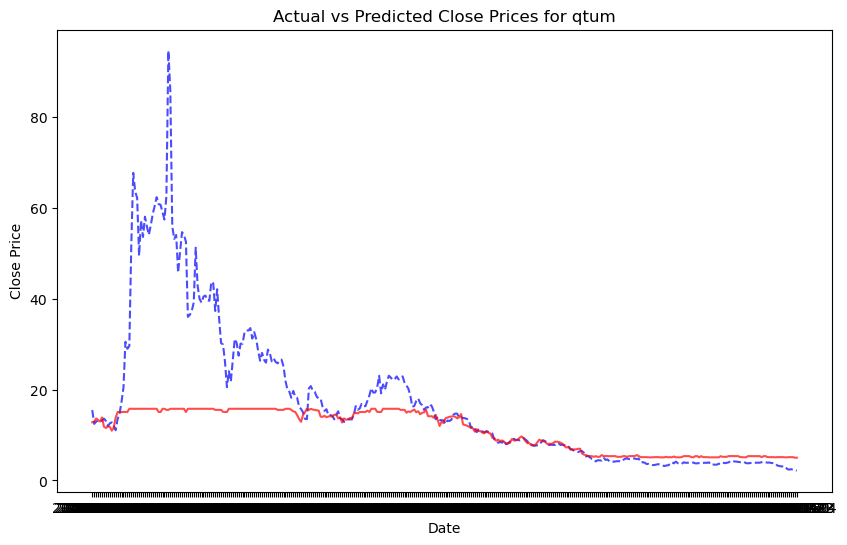

In [7]:
# Function to load dataset from file and apply basic data cleaning
def load_coin_data(data_file='../../data/crypto-markets.csv'):
    try:
        df = pd.read_csv(data_file)
    except FileNotFoundError:
        print("ERROR: data file not found")
        return None
    
    # Convert date column from string to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Align all end dates to '2018-11-29'
    df = df[df['date'] != '2018-11-30']

    # Sort the dataset by 'slug' and 'date'
    df = df.sort_values(['slug', 'date'])

    # Add next closing price and next day return columns
    df['next_close'] = df.groupby('slug')['close'].shift(-1)
    df['next_return'] = (df['next_close'] - df['close']) / df['close']

    # Drop the last row of each coin as we don't have the next day's closing price
    df = df.dropna()

    # Reset the dataframe index
    df = df.reset_index(drop=True)

    return df

# Function to filter dataset to only contain coins with specific number of years of data
def filter_by_years(df, years=4):
    return df.groupby('slug').filter(lambda x: len(x) > (365 * years)).reset_index(drop=True)

# Function to split dataset by specific date
def split_train_test(df, date='2017-11-28'):
    train = df.loc[df['date'] < date].reset_index(drop=True)
    test = df.loc[df['date'] >= date].reset_index(drop=True)
    return train, test

# Get unique slugs
slugs = df['slug'].unique()

# Initialize a dictionary to store results
results = {}

# Loop over each slug
for slug in slugs:
    print(f"\nProcessing slug: {slug}")
    
    # Filter data for the current slug
    slug_data = df[df['slug'] == slug].copy()

    # Skip slugs with insufficient data
    if slug_data.shape[0] < 10:
        print(f"Skipping {slug} due to insufficient data.")
        continue
    
    # Sort data by date in ascending order (earliest to latest)
    slug_data.sort_values('date', ascending=False, inplace=True)
    
    # Create lagged features (T-1 to T-5)
    for lag in range(1, 6):
        slug_data[f'T-{lag}'] = slug_data['close'].shift(lag)
    
    # Calculate Moving Average (MA_5) and its percentage change
    slug_data['MA_5'] = slug_data['close'].rolling(window=5, min_periods=1).mean()
    slug_data['MA_5_change%'] = (slug_data['MA_5'] / slug_data['close'].shift(1) - 1) * 100

    # Drop rows with NaN values resulting from shifting
    slug_data.dropna(inplace=True)
    
    # Split data into train and test datasets using the custom split function
    train, test = split_train_test(slug_data)

    # Define features (X) and target (y)
    feature_cols = ['T-1', 'T-2', 'T-3', 'T-4', 'T-5', 'MA_5_change%']
    X_train = train[feature_cols]
    y_train = train['close']
    X_test = test[feature_cols]
    y_test = test['close']
    
    if X_train.empty or X_test.empty:
        print(f"Skipping {slug} due to empty train/test datasets.")
        continue

    # Standardize features
    scaler = MinMaxScaler()
    try:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    except ValueError as e:
        print(f"Skipping {slug} due to scaling error: {e}")
        continue

    # Perform grid search with cross-validation to find the best k
    param_grid = {'n_neighbors': range(1, 21)}  # Test k from 1 to 20
    knn = KNeighborsRegressor()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best value for k
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Best k: {best_k}")

    # Train the final KNN model using the best k
    best_knn = grid_search.best_estimator_

    # Make predictions
    y_pred = best_knn.predict(X_test_scaled)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    explained_variance = explained_variance_score(y_test, y_pred)
    max_error_value = max_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    
    # Create a DataFrame for metrics
    metrics = {
        'Metric': ['Explained Variance', 'Max Error', 'RMSE', 'MAE', 'R-Squared'],
        'Value': [explained_variance, max_error_value, rmse, mae, r_squared]
    }
    metrics_df = pd.DataFrame(metrics)
    
    # Store results
    results[slug] = {
        'best_k': best_k,
        'metrics': metrics_df,
        'model': best_knn,
        'scaler': scaler
    }

    # Print the performance metrics table
    print(f"Performance Metrics for {slug}:")
    print(metrics_df)
    
    # Graph 1: Error distribution plot
    error = y_test - y_pred
    sns.displot(error, kde=True, bins=40)
    plt.title(f"Error Distribution for {slug}")
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

    # Graph 2: Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    test_sorted = test.sort_values(by='date')
    plt.plot(test_sorted['date'], y_test.loc[test_sorted.index].values, label='Actual Values', color='blue', linestyle='dashed', alpha=0.7)
    plt.plot(test_sorted['date'], y_pred[test_sorted.index], label='Predicted Values', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted Close Prices for {slug}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid(True)
    plt.show()

# Final Results Summary
print("\nFinal Results Summary:")
for slug, res in results.items():
    print(f"\nSlug: {slug}")
    print(f"Best k: {res['best_k']}")
    print("Metrics:")
    print(res['metrics'])